### Extracting features from Satelleite imagery and clustering areas into groups based on these features, to identify housing-submnarkets 

The following notebook implements the MOSAIKs model to extract features from satelleiete imagery in Madrid. The features are extracted for different patch sizes and then these features are clustered to create housing sub-markets. We finally calculate some internal validation scores to assess the cluster quality across scales.

In [68]:
# Read in packages
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from dask.distributed import Client
import pystac_client
import planetary_computer as pc
import contextily as cx
import geopandas as gpd
from sklearn.cluster import KMeans
from shapely import wkt
from sklearn.preprocessing import robust_scale
warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="sklearn")
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from shapely.geometry import shape
from shapely.geometry import Point, box

import gap_statistic
from gap_statistic import OptimalK


warnings.filterwarnings("ignore")


In [69]:
!pip install torch


In [70]:
!pip install gap-stat

### Data Preparation

In [71]:
# Read in shapefile of Madrid with district boundaries
db = gpd.read_file('Distritos.shp')
# Set local crs in m 
db = db.to_crs(25830)

In [72]:
# Initialize grid_list
grid_list = []

# Set the initial CRS and step size
crs = '25830'
initial_step = 300

# Total bounds of the original GeoDataFrame (assuming it's called db)
a, b, c, d = db.total_bounds

# Create a grid for geometry with step size 300
gdf_grid = gpd.GeoDataFrame(
    geometry=[
        shapely.geometry.box(minx, miny, maxx, maxy)
        for minx, maxx in zip(np.arange(a, c, initial_step), np.arange(a, c, initial_step)[1:])
        for miny, maxy in zip(np.arange(b, d, initial_step), np.arange(b, d, initial_step)[1:])
    ],
    crs=crs,
).to_crs(db.crs)

# Append the grid to grid_list
grid_list.append(gdf_grid)


# Create grids to patch image
# Change the step size to change sizes
# Set the initial CRS and step size
crs = '25830'
initial_step = 500
final_step = 4000
step_increase = 400


# Loop through step sizes
for STEP in range(initial_step, final_step + 1, step_increase):
    # Total bounds of the original GeoDataFrame (assuming it's called db)
    a, b, c, d = db.total_bounds

    # Create a grid for geometry
    gdf_grid = gpd.GeoDataFrame(
        geometry=[
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in zip(np.arange(a, c, STEP), np.arange(a, c, STEP)[1:])
            for miny, maxy in zip(np.arange(b, d, STEP), np.arange(b, d, STEP)[1:])
        ],
        crs=crs,
    ).to_crs(db.crs)

    # Append the current GeoDataFrame to the list
    grid_list.append(gdf_grid)


In [73]:
grid_list[0]

,geometry
0,"POLYGON ((425053.609 4462565.990, 425053.609 4..."
1,"POLYGON ((425053.609 4462865.990, 425053.609 4..."
2,"POLYGON ((425053.609 4463165.990, 425053.609 4..."
3,"POLYGON ((425053.609 4463465.990, 425053.609 4..."
4,"POLYGON ((425053.609 4463765.990, 425053.609 4..."
...,...
12683,"POLYGON ((455953.609 4497665.990, 455953.609 4..."
12684,"POLYGON ((455953.609 4497965.990, 455953.609 4..."
12685,"POLYGON ((455953.609 4498265.990, 455953.609 4..."
12686,"POLYGON ((455953.609 4498565.990, 455953.609 4..."


## Satelleite data


In [74]:
# Create a points dataframe to retrieve satelleite imagery
grid_list[9].crs = "EPSG:25830"

# Create a new GeoDataFrame with centroids pf grid cells
points = gpd.GeoDataFrame(geometry=grid_list[9].geometry.centroid, crs=grid_list[9].crs)


In [75]:
# Use dask to partition the data for one dataframe

NPARTITIONS = 250

ddf = dask_geopandas.from_geopandas(points, npartitions=1)
#hd = ddf.hilbert_distance().compute()
#points["hd"] = hd
#points = points.sort_values("hd")
points = points.to_crs(4326)

dgdf = dask_geopandas.from_geopandas(points, npartitions=NPARTITIONS, sort=False)

In [76]:
# Use STAC to fetch satelleite imagery
time_of_interest = "2019-02-13"

def query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull)
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }

    index = []

    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = geopandas.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)

In [77]:
# Assign stac item to df2
%time

with Client(n_workers=16) as client:
    print(client.dashboard_link)
    meta = dgdf._meta.assign(stac_item=[])
    df2 = dgdf.map_partitions(query, meta=meta).compute()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 17.4 µs
/user/g.e.kenyon@liverpool.ac.uk/proxy/8787/status


/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:856: FutureWarning: get_all_items_as_dict() is deprecated, use item_collection_as_dict() instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:856: FutureWarning: get_all_items_as_dict() is deprecated, use item_collection_as_dict() instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:856: FutureWarning: get_all_items_as_dict() is deprecated, use item_collection_as_dict() instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:856: FutureWarning: get_all_items_as_dict() is deprecated, use item_collection_as_dict() instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:856: FutureWarning: get_all_items_as_dict() is deprecated, use item_collection_as_dict() instead.
  warnings.warn(
/srv/conda

In [78]:
# Assuming 'grid_list' is your list of GeoDataFrames
for idx, gdf_grid in enumerate(grid_list):
    # Access the 'stac_item' dictionary for the specified row in df2
    stac_item_dict = df2.loc[idx, 'stac_item']

    # Repeat the 'stac_item' value for the entire length of the GeoDataFrame
    repeated_stac_item = pd.Series([stac_item_dict] * len(gdf_grid), index=gdf_grid.index)

    # Assign the repeated 'stac_item' to the 'stac_item' column in the current GeoDataFrame
    gdf_grid['stac_item'] = repeated_stac_item



In [79]:
# Create a list to store matching URLs for each GeoDataFrame
matching_urls_list = []

for idx, gdf_grid in enumerate(grid_list):
    # Access the 'stac_item' dictionary for the specified row in df2
    stac_item_dict = df2.loc[idx, 'stac_item']

    # Extract the 'visual' asset href from the 'stac_item' dictionary
    visual_href = stac_item_dict["assets"]["visual"]["href"]

    # Sign the URL
    signed_url = pc.sign(visual_href)

    # Create a list with the signed URL repeated for each observation in the GeoDataFrame
    matching_urls = [signed_url] * len(gdf_grid)

    # Append the list of matching URLs to the overall list
    matching_urls_list.append(matching_urls)


In [80]:
# The length of urls and grid squares should match
for idx, (urls, grid_list) in enumerate(zip(matching_urls_list, grid_list)):
    print(f"Length of GeoDataFrame at index {idx}: {len(grid_list)}")
    print(f"Length of matching URLs at index {idx}: {len(urls)}")

Length of GeoDataFrame at index 0: 12688
Length of matching URLs at index 0: 12688
Length of GeoDataFrame at index 1: 4526
Length of matching URLs at index 1: 4526
Length of GeoDataFrame at index 2: 1360
Length of matching URLs at index 2: 1360
Length of GeoDataFrame at index 3: 672
Length of matching URLs at index 3: 672
Length of GeoDataFrame at index 4: 378
Length of matching URLs at index 4: 378
Length of GeoDataFrame at index 5: 238
Length of matching URLs at index 5: 238
Length of GeoDataFrame at index 6: 168
Length of matching URLs at index 6: 168
Length of GeoDataFrame at index 7: 120
Length of matching URLs at index 7: 120
Length of GeoDataFrame at index 8: 99
Length of matching URLs at index 8: 99
Length of GeoDataFrame at index 9: 72
Length of matching URLs at index 9: 72


### Patch Satelleite data

In [81]:
# define custom pytorch dataset to load raster data, cropping it based on grid cell geometries, and providing the preprocessed image data for training or inference in PyTorch.
class CustomDataset(Dataset):
    def __init__(self, gdf_grid, fns):
        self.gdf_grid = gdf_grid
        self.fns = fns


    def __len__(self):
        return len(self.gdf_grid)

    def __getitem__(self, idx):
        fn = self.fns[idx]

        if fn is None:
            return None
        else:
            # Get the geometry of the current grid cell
            grid_geom = self.gdf_grid.iloc[idx].geometry

            with rasterio.Env():
                with rasterio.open(fn, "r") as f:
                    # Crop the raster to the grid cell
                    out_image, out_transform = rasterio.mask.mask(
                        f, [shapely.geometry.mapping(grid_geom)], crop=True
                    )
            # Get the dimensions of the valid part of the image
            height, width = out_image.shape[1:]

            # Remove the last row and column
            out_image = out_image[:, :height - 1, :width - 1]

    
            out_image = out_image / 255.0
            out_image = torch.from_numpy(out_image).float()

            # Return the image
            return out_image


In [82]:
# Initialize grid_list
grid_list = []

# Set the initial CRS and step size
crs = '25830'
initial_step = 300

# Total bounds of the original GeoDataFrame (assuming it's called db)
a, b, c, d = db.total_bounds

# Create a grid for geometry with step size 300
gdf_grid = gpd.GeoDataFrame(
    geometry=[
        shapely.geometry.box(minx, miny, maxx, maxy)
        for minx, maxx in zip(np.arange(a, c, initial_step), np.arange(a, c, initial_step)[1:])
        for miny, maxy in zip(np.arange(b, d, initial_step), np.arange(b, d, initial_step)[1:])
    ],
    crs=crs,
).to_crs(db.crs)

# Append the grid to grid_list
grid_list.append(gdf_grid)


# Create grids to patch image
# Change the step size to change sizes
# Set the initial CRS and step size
crs = '25830'
initial_step = 500
final_step = 4000
step_increase = 400


# Loop through step sizes
for STEP in range(initial_step, final_step + 1, step_increase):
    # Total bounds of the original GeoDataFrame (assuming it's called db)
    a, b, c, d = db.total_bounds

    # Create a grid for geometry
    gdf_grid = gpd.GeoDataFrame(
        geometry=[
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in zip(np.arange(a, c, STEP), np.arange(a, c, STEP)[1:])
            for miny, maxy in zip(np.arange(b, d, STEP), np.arange(b, d, STEP)[1:])
        ],
        crs=crs,
    ).to_crs(db.crs)

    # Append the current GeoDataFrame to the list
    grid_list.append(gdf_grid)


In [83]:
# List to store dataloaders
dataloaders = []

# Iterate over each item in processed_points_list
for idx in range(len(grid_list)):
    # Increase buffer size in increments of 50
    # Create a CustomDataset for each item with the respective buffer size
    dataset = CustomDataset(grid_list[idx], matching_urls_list[idx])

    # Create a DataLoader for each dataset
    dataloader = DataLoader(
        dataset,
        batch_size=8,
        shuffle=False,
        num_workers=os.cpu_count() * 2,
        collate_fn=lambda x: x,
        pin_memory=False,
    )

    # Append the dataloader to the list
    dataloaders.append(dataloader)

In [84]:
# Pick a dataloder to visualise - different scales
first_dataloader = dataloaders[0]

Image Dimensions: torch.Size([3, 30, 30])


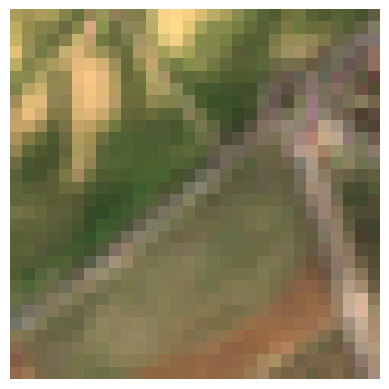

In [85]:
# Display an image patch 
# Assuming you want to display the first image patch
desired_patch_index = 1

# Assuming dataloader_0 contains the images
images = next(iter(first_dataloader))

# Select the desired patch
image = images[desired_patch_index]

if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
    # Print the dimensions of the image
    print("Image Dimensions:", image.shape)



    # Visualize the image
plt.imshow(image.permute(1, 2, 0))  # Assuming image is (C, H, W) and you want to convert to (H, W, C)
plt.axis('off')
plt.show()


### Run the model 

In [86]:
class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""

    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3):
        super(RCF, self).__init__()

        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0

        self.num_features = num_features  # Store num_features as an instance variable

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, -1.0)

    def forward(self, x):
        x1a = F.relu(self.conv1(x), inplace=True)
        x1b = F.relu(-self.conv1(x), inplace=True)

        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()

        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)


In [87]:
# Define the numbers of features for each model
feature_numbers = [100, 500, 1000, 2000]

# Create a list to store models
models = []

# Create models with different numbers of features
for num_features in feature_numbers:
#    device = torch.device("cuda")
    model = RCF(num_features=num_features).eval().to()
    models.append(model)


In [88]:
#store centroid of patch co-ordinates
processed_grid_list = []

for gdf_grid in grid_list:
    # Change to m crs if needed
    gdf_grid = gdf_grid.to_crs(25830)

    # Calculate the centroid of each polygon
    centroids = gdf_grid.geometry.centroid

    # Create a DataFrame with centroid coordinates
    centroids_df = gpd.GeoDataFrame(geometry=centroids, crs=gdf_grid.crs)
    centroids_df['west'] = centroids_df.geometry.x
    centroids_df['east'] = centroids_df.geometry.y

    # Extract necessary columns to form numpy array
    centroids_array = centroids_df[["west", "east"]].to_numpy()

    # Append only the array to the processed_grid_list
    processed_grid_list.append(centroids_array)



### Models

We now run the model for different scales, we do this separately to not overload the memory. We start with the widest scale and work down to the smallest.

In [89]:
# Create a dictionary to store results for each model
output_dict9 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[9].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[9]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[9].shape[0]} -- {i / processed_grid_list[9].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[9].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[9].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict9[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict9.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/72 -- 0.00% -- 3.49 seconds
0/72 -- 0.00% -- 3.60 seconds
0/72 -- 0.00% -- 3.82 seconds
0/72 -- 0.00% -- 3.78 seconds
Results for model with 100 features:
[[0.         1.38054872 1.41883326 ... 2.96676683 2.00489902 0.21392314]
 [0.         1.15988469 1.31107295 ... 2.87394643 1.9663049  0.1459052 ]
 [0.         0.88463676 1.01130664 ... 2.60314846 1.828071   0.22929783]
 ...
 [0.         0.97611982 1.11941266 ... 2.71720338 1.88596189 0.18096825]
 [0.         0.91279328 1.1417712  ... 2.7465024  1.89951587 0.15911126]
 [0.         1.19146526 1.37046134 ... 2.92962742 1.99208891 0.15299864]]
Results for model with 500 features:
[[5.17911613e-01 4.20140076e+00 1.14497216e-02 ... 2.44811916e+00
  6.83124131e-03 2.72062707e+00]
 [4.62471098e-01 4.05944300e+00 5.62252663e-03 ... 2.46237135e+00
  1.63196784e-03 2.76617551e+00]
 [3.55218887e-01 3.34240508e+00 5.00541693e-03 ... 2.26258469e+00
  2.87572686e-02 2.51805735e+00]
 ...
 [3.53486538e-01 3.63706732e+00 1.25826960e-02 ... 2.3411474

In [42]:
# Create a dictionary to store results for each model
output_dict8 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[8].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[8]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[8].shape[0]} -- {i / processed_grid_list[8].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[8].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[8].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict8[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict8.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/99 -- 0.00% -- 3.14 seconds
0/99 -- 0.00% -- 3.61 seconds
0/99 -- 0.00% -- 3.86 seconds
0/99 -- 0.00% -- 4.48 seconds
Results for model with 100 features:
[[0.         1.77074945 0.83179665 ... 5.09213543 0.08562321 4.71948481]
 [0.         1.71507907 0.82368302 ... 4.98868275 0.07152402 4.6389122 ]
 [0.         1.45019329 0.74532843 ... 4.82351446 0.09175567 4.46620131]
 ...
 [0.         1.31661367 0.67674124 ... 4.75376129 0.09502747 4.38814068]
 [0.         1.69944453 0.88816428 ... 5.23091936 0.07905821 4.82740974]
 [0.         1.2866776  0.66892815 ... 4.6839118  0.10340425 4.32262993]]
Results for model with 500 features:
[[4.47154045e-03 4.55908149e-01 9.98329744e-03 ... 3.85451913e+00
  1.08361233e-03 2.81956387e+00]
 [9.41151578e-04 4.07022238e-01 3.84491822e-03 ... 3.79792237e+00
  1.00265279e-04 2.79243302e+00]
 [3.53787298e-04 3.43103588e-01 1.17099541e-03 ... 3.56408286e+00
  1.54375529e-03 2.72618866e+00]
 ...
 [1.66637212e-04 2.90836453e-01 6.54816686e-04 ... 3.4503777

In [43]:
# Create a dictionary to store results for each model
output_dict7 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[7].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[7]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[7].shape[0]} -- {i / processed_grid_list[7].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[7].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[7].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict7[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict7.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/120 -- 0.00% -- 3.73 seconds
0/120 -- 0.00% -- 3.99 seconds
0/120 -- 0.00% -- 4.28 seconds
0/120 -- 0.00% -- 4.59 seconds
Results for model with 100 features:
[[0.         1.72146857 0.80521089 ... 5.04756451 0.09230165 4.68172455]
 [0.         1.84701061 0.87392282 ... 5.11611795 0.0684047  4.75493288]
 [0.         1.35743403 0.71657556 ... 4.76115561 0.08637787 4.40840626]
 ...
 [0.         1.33093262 0.67561001 ... 4.78017426 0.0967265  4.41284132]
 [0.         1.58849084 0.80054474 ... 5.02584839 0.07864507 4.6380868 ]
 [0.         1.36591625 0.73659801 ... 4.82998943 0.11043853 4.45337915]]
Results for model with 500 features:
[[5.06723905e-03 4.43257689e-01 1.03041548e-02 ... 3.80953908e+00
  9.73991933e-04 2.79907298e+00]
 [1.43676577e-03 4.53069508e-01 5.18154493e-03 ... 3.92026091e+00
  1.64197641e-04 2.84296417e+00]
 [1.24434635e-04 3.07752520e-01 5.76554623e-04 ... 3.48355961e+00
  8.46213370e-04 2.70495224e+00]
 ...
 [1.93817104e-04 2.95960099e-01 6.08828559e-04 ... 3.466

In [44]:
# Create a dictionary to store results for each model
output_dict6 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[6].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[6]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[6].shape[0]} -- {i / processed_grid_list[6].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[6].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[6].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict6[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict6.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/168 -- 0.00% -- 3.85 seconds
0/168 -- 0.00% -- 4.60 seconds
0/168 -- 0.00% -- 4.86 seconds
0/168 -- 0.00% -- 4.83 seconds
Results for model with 100 features:
[[0.         1.77366734 0.83869898 ... 5.12511396 0.08807686 4.75160551]
 [0.         1.92188537 0.90313524 ... 5.19471693 0.06666972 4.82874441]
 [0.         1.40932131 0.72052556 ... 4.77882528 0.08098996 4.42251015]
 ...
 [0.         1.33232999 0.69621897 ... 4.79089832 0.07945205 4.41193438]
 [0.         1.9413029  1.02299702 ... 5.47845268 0.06710782 5.06791735]
 [0.         1.6101377  0.90756166 ... 5.16988897 0.07912271 4.76398087]]
Results for model with 500 features:
[[5.50511619e-03 4.64015454e-01 1.13782752e-02 ... 3.86102843e+00
  8.98728264e-04 2.82976246e+00]
 [1.77838979e-03 4.81901586e-01 6.27475092e-03 ... 3.99362111e+00
  3.79243924e-04 2.87803650e+00]
 [4.25454520e-04 3.19728345e-01 1.69104885e-03 ... 3.52515268e+00
  1.56813912e-04 2.70718145e+00]
 ...
 [1.21359073e-04 2.93782651e-01 4.85357712e-04 ... 3.471

In [45]:
# Create a dictionary to store results for each model
output_dict5 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[5].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[5]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[5].shape[0]} -- {i / processed_grid_list[5].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[5].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[5].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict5[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict5.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/238 -- 0.00% -- 4.83 seconds
0/238 -- 0.00% -- 4.93 seconds
0/238 -- 0.00% -- 4.93 seconds
0/238 -- 0.00% -- 5.16 seconds
Results for model with 100 features:
[[0.         1.82534957 0.88032842 ... 5.22850657 0.08194213 4.84075117]
 [0.         1.73868668 0.82147884 ... 5.06010675 0.07840274 4.69467783]
 [0.         1.56838751 0.69791359 ... 4.66540861 0.09817983 4.3548913 ]
 ...
 [0.         1.83608627 0.91913772 ... 5.22769165 0.07325838 4.83504963]
 [0.         1.8818953  1.08477473 ... 5.68228006 0.0774403  5.21878624]
 [0.         1.39062345 0.75789297 ... 4.92128372 0.07619312 4.53097343]]
Results for model with 500 features:
[[6.04916736e-03 4.86535251e-01 1.10166296e-02 ... 3.92038274e+00
  9.51347873e-04 2.87560987e+00]
 [1.56593416e-03 4.28456187e-01 6.08962728e-03 ... 3.82851434e+00
  6.31139730e-04 2.81587887e+00]
 [1.59179792e-03 3.45585555e-01 4.96854167e-03 ... 3.62450385e+00
  2.49328295e-04 2.64537501e+00]
 ...
 [4.81503957e-04 4.73937809e-01 1.22379733e-03 ... 3.934

In [46]:
# Create a dictionary to store results for each model
output_dict4 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[4].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[4]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[4].shape[0]} -- {i / processed_grid_list[4].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[4].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[4].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict4[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict4.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/378 -- 0.00% -- 4.45 seconds
0/378 -- 0.00% -- 4.87 seconds
0/378 -- 0.00% -- 6.12 seconds
0/378 -- 0.00% -- 5.70 seconds
Results for model with 100 features:
[[0.         1.81773102 0.88747257 ... 5.23759794 0.08180258 4.84602213]
 [0.         1.87970054 0.8854754  ... 5.19445276 0.07444501 4.82658148]
 [0.         1.96186304 0.90993077 ... 5.17710638 0.07064674 4.83210707]
 ...
 [0.         1.92412364 0.97272497 ... 5.18384409 0.0904038  4.84477186]
 [0.         1.60411429 0.82987916 ... 5.03209591 0.08754791 4.65120935]
 [0.         1.54888833 0.83338022 ... 4.85064554 0.04282106 4.5189085 ]]
Results for model with 500 features:
[[6.77983742e-03 4.86570358e-01 1.10856593e-02 ... 3.91488910e+00
  1.26336433e-03 2.88220024e+00]
 [1.82556501e-03 4.85809118e-01 7.39659695e-03 ... 3.96224642e+00
  8.13114690e-04 2.87584901e+00]
 [2.10330449e-03 4.86897230e-01 6.62286114e-03 ... 4.02280998e+00
  7.57150337e-05 2.87244892e+00]
 ...
 [9.01787658e-04 5.05864203e-01 1.15317723e-03 ... 3.995

In [47]:
# Create a dictionary to store results for each model
output_dict3 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[3].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[3]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[3].shape[0]} -- {i / processed_grid_list[3].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[3].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[3].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict3[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict3.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/672 -- 0.00% -- 4.32 seconds
0/672 -- 0.00% -- 5.62 seconds
0/672 -- 0.00% -- 5.96 seconds
0/672 -- 0.00% -- 5.96 seconds
Results for model with 100 features:
[[0.         1.92121243 0.95775342 ... 5.36362028 0.06805428 4.9663372 ]
 [0.         1.76122701 0.83530915 ... 5.08644485 0.09002601 4.72175026]
 [0.         1.8949815  0.91027963 ... 5.26403046 0.0585848  4.89139128]
 ...
 [0.         1.76686108 1.00851607 ... 5.45590544 0.05900662 5.02705288]
 [0.         1.43231273 0.76554483 ... 4.69423962 0.06514923 4.36766052]
 [0.         1.51728988 0.84695292 ... 4.96696711 0.04397885 4.58829212]]
Results for model with 500 features:
[[2.12762691e-03 5.19280076e-01 1.11057237e-02 ... 4.01484776e+00
  6.43840351e-04 2.94015813e+00]
 [6.49107620e-03 4.56138551e-01 7.69801391e-03 ... 3.84628820e+00
  1.98019529e-03 2.82237315e+00]
 [2.32658247e-04 4.73465025e-01 6.22392399e-03 ... 3.98867464e+00
  1.22071811e-04 2.90649009e+00]
 ...
 [4.23768040e-04 4.97599721e-01 2.48352904e-03 ... 3.924

In [48]:
# Create a dictionary to store results for each model
output_dict2 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[2].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[2]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[2].shape[0]} -- {i / processed_grid_list[2].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[2].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[2].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict2[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict2.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/1360 -- 0.00% -- 4.82 seconds
1000/1360 -- 73.53% -- 10.52 seconds
0/1360 -- 0.00% -- 4.98 seconds
1000/1360 -- 73.53% -- 13.66 seconds
0/1360 -- 0.00% -- 4.57 seconds
1000/1360 -- 73.53% -- 25.08 seconds
0/1360 -- 0.00% -- 4.60 seconds
1000/1360 -- 73.53% -- 40.79 seconds
Results for model with 100 features:
[[0.         1.76099789 0.92768496 ... 5.34167767 0.06672831 4.93575525]
 [0.         1.7409023  0.87958747 ... 5.27623558 0.07124543 4.87951565]
 [0.         1.92570937 0.91790628 ... 5.24346352 0.06450409 4.86399555]
 ...
 [0.         2.00502634 1.02688169 ... 5.46041203 0.05147639 5.04372072]
 [0.         1.26115501 0.65220362 ... 4.22550583 0.05613609 3.98517537]
 [0.         1.57442701 0.86556101 ... 4.99746609 0.03175849 4.61234617]]
Results for model with 500 features:
[[1.55125943e-03 4.77706432e-01 5.31995622e-03 ... 3.89117670e+00
  8.49495875e-04 2.93736243e+00]
 [1.04227727e-02 4.68618006e-01 3.34559707e-03 ... 3.86562133e+00
  5.62579371e-04 2.90535665e+00]
 [1.2911

In [49]:
# Create a dictionary to store results for each model
output_dict1 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[1].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[1]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[1].shape[0]} -- {i / processed_grid_list[1].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[1].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[1].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict1[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict1.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/4526 -- 0.00% -- 5.13 seconds
1000/4526 -- 22.09% -- 8.68 seconds
2000/4526 -- 44.19% -- 7.24 seconds
3000/4526 -- 66.28% -- 7.62 seconds
4000/4526 -- 88.38% -- 6.81 seconds
0/4526 -- 0.00% -- 4.06 seconds
1000/4526 -- 22.09% -- 9.36 seconds
2000/4526 -- 44.19% -- 8.85 seconds
3000/4526 -- 66.28% -- 7.65 seconds
4000/4526 -- 88.38% -- 7.58 seconds
0/4526 -- 0.00% -- 4.77 seconds
1000/4526 -- 22.09% -- 11.03 seconds
2000/4526 -- 44.19% -- 11.93 seconds
3000/4526 -- 66.28% -- 8.94 seconds
4000/4526 -- 88.38% -- 9.85 seconds
0/4526 -- 0.00% -- 4.78 seconds
1000/4526 -- 22.09% -- 15.48 seconds
2000/4526 -- 44.19% -- 15.41 seconds
3000/4526 -- 66.28% -- 15.44 seconds
4000/4526 -- 88.38% -- 15.27 seconds
Results for model with 100 features:
[[0.         1.62965119 0.90413731 ... 5.45652533 0.04250801 4.98189735]
 [0.         1.59969854 1.03635263 ... 5.38228083 0.04110231 4.97291756]
 [0.         1.75458694 0.96645612 ... 5.60029602 0.04903146 5.13469172]
 ...
 [0.         1.34001005 0.732

In [50]:
# Create a dictionary to store results for each model
output_dict0 = {}

# Loop over each model
for model in models:
    x_all = np.zeros((processed_grid_list[0].shape[0], model.num_features), dtype=float)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[0]:
        for image in images:
            if image is not None and image.shape[0] >= 0 and image.shape[2] >= 0:
                image = image.to()
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[0].shape[0]} -- {i / processed_grid_list[0].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[0].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[0].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict0[model.num_features] = x_all

# Access the results for each model
for num_features, x_all in output_dict0.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

0/12688 -- 0.00% -- 3.73 seconds
1000/12688 -- 7.88% -- 8.05 seconds
2000/12688 -- 15.76% -- 6.05 seconds
3000/12688 -- 23.64% -- 7.14 seconds
4000/12688 -- 31.53% -- 6.79 seconds
5000/12688 -- 39.41% -- 6.57 seconds
6000/12688 -- 47.29% -- 5.49 seconds
7000/12688 -- 55.17% -- 6.87 seconds
8000/12688 -- 63.05% -- 6.28 seconds
9000/12688 -- 70.93% -- 6.42 seconds
10000/12688 -- 78.81% -- 6.56 seconds
11000/12688 -- 86.70% -- 6.29 seconds
12000/12688 -- 94.58% -- 5.88 seconds
0/12688 -- 0.00% -- 4.40 seconds
1000/12688 -- 7.88% -- 7.58 seconds
2000/12688 -- 15.76% -- 7.42 seconds
3000/12688 -- 23.64% -- 8.08 seconds
4000/12688 -- 31.53% -- 7.58 seconds
5000/12688 -- 39.41% -- 7.15 seconds
6000/12688 -- 47.29% -- 6.41 seconds
7000/12688 -- 55.17% -- 7.79 seconds
8000/12688 -- 63.05% -- 6.96 seconds
9000/12688 -- 70.93% -- 6.85 seconds
10000/12688 -- 78.81% -- 6.37 seconds
11000/12688 -- 86.70% -- 8.38 seconds
12000/12688 -- 94.58% -- 7.66 seconds
0/12688 -- 0.00% -- 4.47 seconds
1000/1268

### Cluster the patches based on features

In [95]:
# Create a DataFrame to store the scores
scores_df = pd.DataFrame(columns=[
    'sil_score',
    'cal_score',
    'db_score',
    'gap_stat',
    'num_feats',
    'num_clus',
    'scale'
])

In [96]:
# Set the fixed number of clusters
cluster_sizes = [3, 10, 18, 25]


In [97]:
labels_dict9 = {}

# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict9.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        # Convert the dictionary to a DataFrame
                # Store labels in the dictionary
        labels_dict9[(num_features, k)] = labels
        labels_df9 = pd.DataFrame(labels_dict9)
        
        # Flatten the multi-level columns into a single level
        labels_df9.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df9.columns]
        labels_df9.to_csv('labels_df9.csv')
        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '370',  # You can adjust this based on your scaling method
#            'gap_stat': 'gap_statistic',
        }, index=[0])], ignore_index=True)



In [66]:
labels_dict8 = {}

# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict8.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
         # Convert the dictionary to a DataFrame
        labels_dict8[(num_features, k)] = labels
        labels_df8 = pd.DataFrame(labels_dict8)
        labels_df8.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df8.columns]
        labels_df8.to_csv('labels_df8.csv')
        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '330',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)



/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
labels_dict7 = {}

# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict7.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict7[(num_features, k)] = labels
        labels_df7 = pd.DataFrame(labels_dict7)
        labels_df7.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df7.columns]
        labels_df7.to_csv('labels_df7.csv')
        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '290',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

In [40]:
labels_dict6 = {}            

# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict6.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict6[(num_features, k)] = labels
        labels_df6 = pd.DataFrame(labels_dict6)
        labels_df6.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df6.columns]
        labels_df6.to_csv('labels_df6.csv')
             
        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '250',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/s

In [41]:
labels_dict5 = {}  

# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict5.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict5[(num_features, k)] = labels
        labels_df5 = pd.DataFrame(labels_dict5)
        labels_df5.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df5.columns]
        labels_df5.to_csv('labels_df5.csv')
             

        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '210',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/e

In [42]:
labels_dict4 = {}  

# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict4.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict4[(num_features, k)] = labels
        labels_df4 = pd.DataFrame(labels_dict4)
        labels_df4.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df4.columns]
        labels_df4.to_csv('labels_df4.csv')
             

        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '170',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/e

In [43]:
labels_dict3 = {}  
# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict3.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict3[(num_features, k)] = labels
        labels_df3 = pd.DataFrame(labels_dict3)
        labels_df3.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df3.columns]
        labels_df3.to_csv('labels_df3.csv')
             
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '130',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/e

In [44]:
labels_dict2 = {}  
# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict2.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict2[(num_features, k)] = labels
        labels_df2 = pd.DataFrame(labels_dict2)
        labels_df2.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df2.columns]
        labels_df2.to_csv('labels_df2.csv')
        

        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '90',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/e

In [45]:
labels_dict1 = {}  
# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict1.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict1[(num_features, k)] = labels
        labels_df1 = pd.DataFrame(labels_dict1)
        labels_df1.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df1.columns]
        labels_df1.to_csv('labels_df1.csv')

        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,     
            'num_clus': k,
            'scale': '50',  # You can adjust this based on your scaling method
        }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid v

In [ ]:
labels_dict0 = {}  
# Iterate over cluster sizes
for k in cluster_sizes:
    # Iterate over different num_features values (assuming they are keys in output_dict8)
    for num_features, data_scaled in output_dict0.items():
        data_scaled = StandardScaler().fit_transform(data_scaled)

        # Fit KMeans model for the original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_scaled)

        # Calculate scores for the original data
        silhouette = silhouette_score(data_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        
        # Convert the dictionary to a DataFrame
        # Convert the dictionary to a DataFrame
        labels_dict0[(num_features, k)] = labels
        labels_df0 = pd.DataFrame(labels_dict0)
        labels_df0.columns = ['{}_{}'.format(col[0], col[1]) for col in labels_df0.columns]
        labels_df0.to_csv('labels_df0.csv')
        
        # Append scores to the DataFrame
        scores_df = pd.concat([scores_df, pd.DataFrame({
            'sil_score': silhouette,
            'cal_score': calinski_harabasz,
            'db_score': davies_bouldin,
            'gap_stat': gap_clusters,
            'num_feats': num_features,
            'num_clus': k,
            'scale': '30'  # You can adjust this based on your scaling method
            }, index=[0])], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/srv/conda/e

In [ ]:
# Save the scores to a csv for further analysis
scores_df.to_csv('scores_cluster2.csv')